<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_4/IMDb_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Perbandingan RNN, LSTM, dan GRU pada Dataset IMDB**
1. Buat model Deep learning (PyTorch and Tensorflow). datasets import imdb, gunakan num_words = 30.000 - 50000 dan maxlen = 300 - 500. buat Kompleks model dengan banyak layer dan neuron.
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC). Visualisasikan matriks akurasi dan loss.
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan
     T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.
5. Bandingkan hasil models RNN, LSTM, dan GRU. Buatlah analisa di format pdf

### Persiapan Awal

In [38]:
import sys
!{sys.executable} -m pip install --upgrade pip --quiet
!{sys.executable} -m pip install tensorflow scikit-learn matplotlib --quiet
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, roc_auc_score, roc_curve,
                             confusion_matrix)

print("✅ Semua library berhasil diimpor.")

✅ Semua library berhasil diimpor.


### Load Dataset

In [39]:
num_words = 50000
maxlen = 500

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print('Train shape:', x_train.shape, 'Label train:', y_train.shape)
print('Test shape :', x_test.shape, 'Label test :', y_test.shape)

Train shape: (25000, 500) Label train: (25000,)
Test shape : (25000, 500) Label test : (25000,)


### Model RNN

In [40]:
def tf_rnn_model(vocab_size, embed_dim=128, hidden_dim=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
        tf.keras.layers.SimpleRNN(hidden_dim, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.SimpleRNN(hidden_dim//2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


### Model LSTM

In [41]:
def tf_lstm_model(vocab_size, embed_dim=128, hidden_dim=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(hidden_dim//2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


### Model GRU

In [42]:
def tf_gru_model(vocab_size, embed_dim=128, hidden_dim=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
        tf.keras.layers.GRU(hidden_dim, return_sequences=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


### Fungsi Training dan Evaluasi

In [43]:
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, batch_size=128, epochs=10):
    print(f"📦 Training model: {model_name}")

    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}.h5", save_best_only=True, monitor='val_loss', verbose=0
    )

    # Training
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    # Evaluation
    print(f"📊 Evaluating model: {model_name}")
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy (from model.evaluate): {acc:.4f}")

    # Predictions
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Classification Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Print scores
    print("\n🔍 Evaluation Metrics:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy & Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    return {
        "model": model,
        "history": history,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score
    }


### Training dan Evaluasi RNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


📦 Training model: RNN_Model
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5057 - loss: 0.7066

157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.5057 - loss: 0.7066 - val_accuracy: 0.5078 - val_loss: 0.6993
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5124 - loss: 0.6994

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.5124 - loss: 0.6994 - val_accuracy: 0.4968 - val_loss: 0.6934
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5200 - loss: 0.6944

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.5201 - loss: 0.6943 - val_accuracy: 0.7008 - val_loss: 0.5752
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7016 - loss: 0.5789 - val_accuracy: 0.6988 - val_loss: 0.5870
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7042 - loss: 0.5618

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7044 - loss: 0.5615 - val_accuracy: 0.7850 - val_loss: 0.4975
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8220 - loss: 0.4085 - val_accuracy: 0.5970 - val_loss: 1.2652
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8416 - loss: 0.3896

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.8417 - loss: 0.3893 - val_accuracy: 0.8138 - val_loss: 0.4773
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8870 - loss: 0.2890 - val_accuracy: 0.7910 - val_loss: 0.5072
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8602 - loss: 0.3177 - val_accuracy: 0.6860 - val_loss: 0.5925
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7653 - loss: 0.4946 - val_accuracy: 0.7312 - val_loss: 0.6030
📊 Evaluating model: RNN_Model
Test Accuracy (from model.evaluate): 0.8164
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step

🔍 Evaluation Metrics:
Accuracy : 0.8164
Precision: 0.8220
Recall   : 0.8077
F1-Score : 0.8148
AUC      : 0.8862


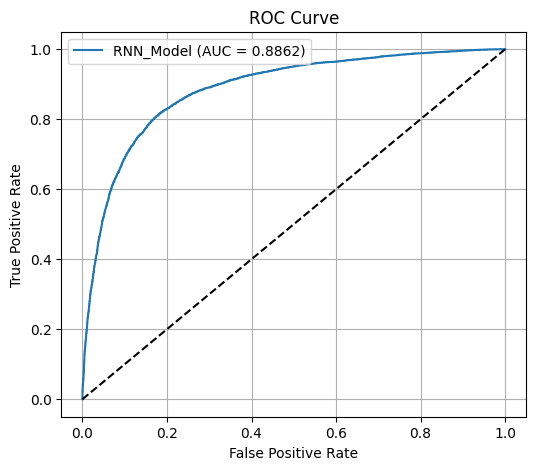

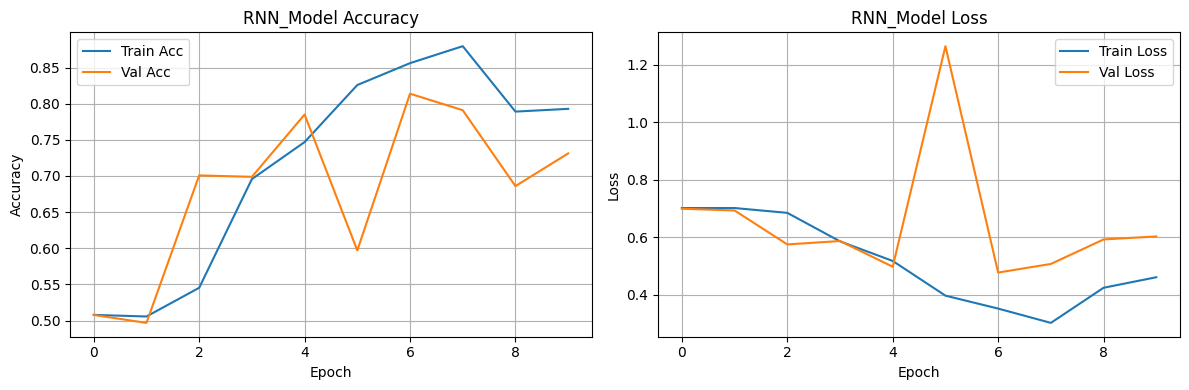

In [44]:
rnn_model = tf_rnn_model(vocab_size=num_words)
rnn_results = train_and_evaluate_model(rnn_model, "RNN_Model", x_train, y_train, x_test, y_test)

### Training Dan Evaluasi LSTM

📦 Training model: LSTM_Model
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6726 - loss: 0.5819

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.6732 - loss: 0.5812 - val_accuracy: 0.8712 - val_loss: 0.3145
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9195 - loss: 0.2137 - val_accuracy: 0.8646 - val_loss: 0.3336
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9543 - loss: 0.1295 - val_accuracy: 0.8700 - val_loss: 0.3828
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9765 - loss: 0.0746 - val_accuracy: 0.8608 - val_loss: 0.5268
📊 Evaluating model: LSTM_Model
Test Accuracy (from model.evaluate): 0.8630
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step

🔍 Evaluation Metrics:
Accuracy : 0.8630
Precision: 0.8827
Recall   : 0.8374
F1-Score : 0.8594
AUC      : 0.9377


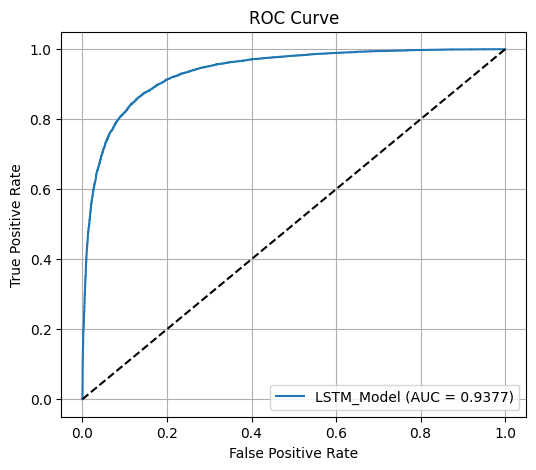

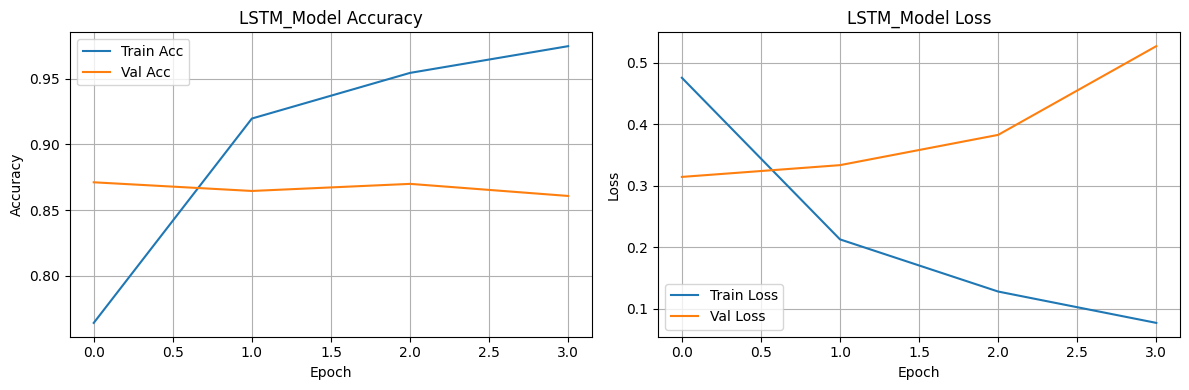

In [45]:
lstm_model = tf_lstm_model(vocab_size=num_words)
lstm_results = train_and_evaluate_model(lstm_model, "LSTM_Model", x_train, y_train, x_test, y_test)

### Training dan Evaluasi GRU

📦 Training model: GRU_Model
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6212 - loss: 0.6328

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6216 - loss: 0.6324 - val_accuracy: 0.5164 - val_loss: 0.6649
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8838 - loss: 0.2986

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8839 - loss: 0.2984 - val_accuracy: 0.6160 - val_loss: 0.6116
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9616 - loss: 0.1117

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9616 - loss: 0.1117 - val_accuracy: 0.7740 - val_loss: 0.5342
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9869 - loss: 0.0417 - val_accuracy: 0.5668 - val_loss: 2.7515
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9919 - loss: 0.0264 - val_accuracy: 0.8372 - val_loss: 0.7929
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9913 - loss: 0.0235 - val_accuracy: 0.8284 - val_loss: 0.8057
📊 Evaluating model: GRU_Model
Test Accuracy (from model.evaluate): 0.7527
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

🔍 Evaluation Metrics:
Accuracy : 0.7527
Precision: 0.9363
Recall   : 0.5422
F1-Score : 0.6868
AUC      : 0.9058


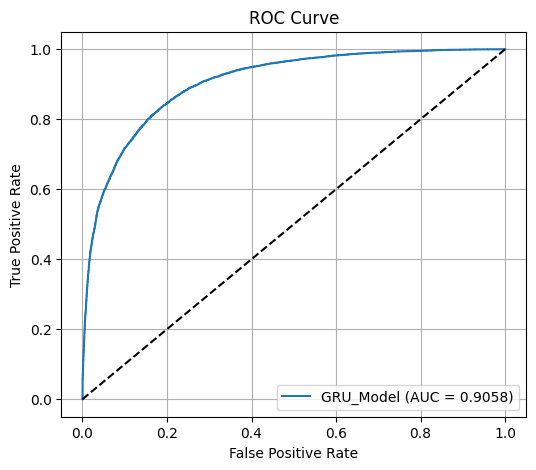

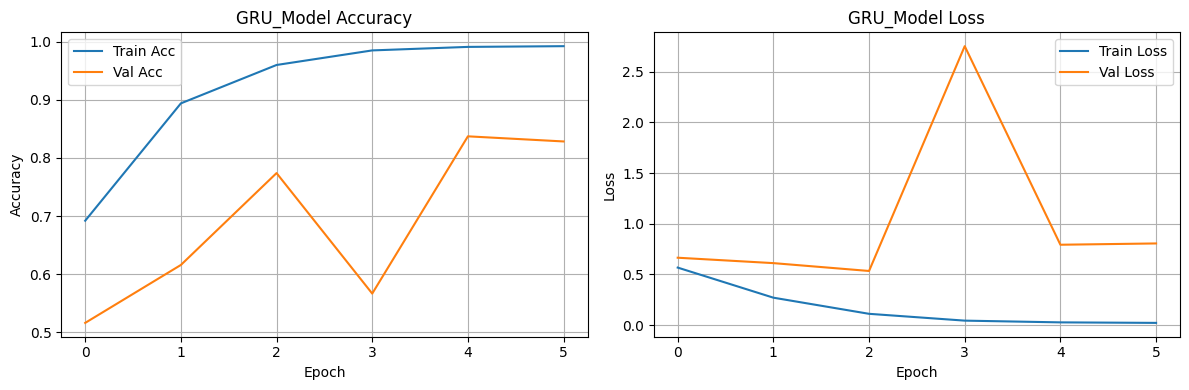

In [47]:
gru_model = tf_gru_model(vocab_size=num_words)
gru_results = train_and_evaluate_model(gru_model, "GRU_Model", x_train, y_train, x_test, y_test)

---

## 🧠 **1. Model Deep Learning (RNN, LSTM, GRU)**

### 🔁 **RNN (Recurrent Neural Network)**

Pada RNN, untuk setiap timestep \( t \):

- **Hidden state**:  
  $$
  h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
  $$

- **Output**:  
  $$
  y_t = W_{hy}h_t + b_y
  $$

📌 Keterangan:
- $ x_t $: input pada waktu \( t \)
- $ h_t $: hidden state saat ini
- $ h_{t-1} $: hidden state sebelumnya
- $ W_{xh}, W_{hh}, W_{hy} $: bobot input, hidden, dan output
- $ b_h, b_y $: bias
- $ \tanh $: fungsi aktivasi non-linear

---

### ⛓️ **LSTM (Long Short-Term Memory)**

LSTM memiliki mekanisme **gates** untuk mengontrol aliran informasi:

$$
\begin{aligned}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \quad &\text{(Forget Gate)} \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \quad &\text{(Input Gate)} \\
\tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \quad &\text{(Candidate State)} \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \quad &\text{(Cell State)} \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \quad &\text{(Output Gate)} \\
h_t &= o_t * \tanh(C_t) \quad &\text{(Hidden State)} \\
\end{aligned}
$$

📌 Fungsi gate:
- $ \sigma $: sigmoid (output antara 0 dan 1)
- $ \tanh $: fungsi aktivasi -1 hingga 1
- $ * $: perkalian elemen-wise

---

### ⚙️ **GRU (Gated Recurrent Unit)**

GRU menyederhanakan LSTM:

$$
\begin{aligned}
z_t &= \sigma(W_z \cdot [h_{t-1}, x_t]) \quad &\text{(Update gate)} \\
r_t &= \sigma(W_r \cdot [h_{t-1}, x_t]) \quad &\text{(Reset gate)} \\
\tilde{h}_t &= \tanh(W_h \cdot [r_t * h_{t-1}, x_t]) \quad &\text{(Candidate state)} \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t \quad &\text{(Final state)} \\
\end{aligned}
$$

📌 GRU lebih ringan dan efisien dibanding LSTM, cocok untuk dataset sedang.

---

## 🏋️‍♀️ **2. Training Model**

### 🎯 **Loss Function: Binary Crossentropy**

Karena IMDb adalah klasifikasi biner, kita pakai:

$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i) \right]
$$

📌 Keterangan:
- $ y_i $: label asli (0 atau 1)
- $ \hat{y}_i $: prediksi model
- $ N $: jumlah data

---

### ⚙️ **Backpropagation dan Optimizer**

Model dilatih menggunakan **Adam Optimizer**, gabungan dari momentum dan RMSprop:

$$
\theta \leftarrow \theta - \eta \cdot \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
$$

📌 $ \hat{m}, \hat{v} $: estimasi rata-rata gradien & kuadrat gradien  
📌 $ \eta $: learning rate

---

## 📈 **3. Evaluasi Model**

### ✅ **Akurasi**
$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$

Berapa banyak prediksi yang benar dibandingkan total data.

---

### 🧪 **Presisi**
$
\text{Precision} = \frac{TP}{TP + FP}
$

Seberapa banyak prediksi positif yang benar-benar positif.

---

### 🔍 **Recall**
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Seberapa banyak data positif yang berhasil dikenali.

---

### ⚖️ **F1-Score**
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Harmonic mean dari Precision dan Recall.

---

### 📊 **AUC (Area Under Curve)**
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \, dFPR
$$

Mengukur kemampuan model membedakan kelas positif dan negatif berdasarkan kurva ROC.

---